<a href="https://colab.research.google.com/github/JoaoRodrigues10/Transfer-Learning-em-Python/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf  # Biblioteca principal para deep learning.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Para pré-processamento das imagens.
from tensorflow.keras.applications import MobileNetV2  # Modelo pré-treinado que usaremos para Transfer Learning.
from tensorflow.keras.models import Sequential  # Para criar um modelo sequencial.
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Camadas da rede.
from tensorflow.keras.optimizers import Adam  # Otimizador para ajuste do modelo.
import numpy as np  # Para manipulação de arrays.
import matplotlib.pyplot as plt  # Para gráficos e visualização de dados.
import os  # Para manipulação de diretórios.


# **O que cada uma faz?**
* **TensorFlow**: Framework principal de aprendizado de máquina usado para construir e treinar redes neurais.
* **ImageDataGenerator**: Auxilia no pré-processamento de imagens, como redimensionar, normalizar e aplicar augmentations.
* **MobileNetV2**: Um modelo de rede neural já treinado para classificar imagens. Usaremos ele para Transfer Learning.
* **Sequential**: Um tipo de modelo onde as camadas são empilhadas em sequência.
* **Camadas** (Dense, Dropout, etc.): Componentes que adicionamos ao modelo para ajustá-lo à nossa tarefa específica.
* **Adam**: Um otimizador eficiente para ajustar pesos da rede.
* **Matplotlib**: Para plotar gráficos de aprendizado.

In [ ]:
import tensorflow_datasets as tfds  # Biblioteca para carregar datasets prontos.

# Carregar o dataset 'cats_vs_dogs' do TensorFlow
dataset, info = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

# Separar em treino e validação
train_data = dataset['train'].take(20000)  # Pega os primeiros 20.000 exemplos para treino.
val_data = dataset['train'].skip(20000)  # Usa o restante para validação.


In [ ]:
IMG_SIZE = 224  # Tamanho das imagens para MobileNetV2.
BATCH_SIZE = 32

def preprocess(image, label):
    # Redimensionar para o tamanho esperado e normalizar (0-1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

# Aplicar preprocessamento no dataset
train_data = train_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# **Explicação:**
1. tfds.load: Carrega um dataset pré-definido, como o de gatos e cachorros. Ele vem com rótulos e imagens prontos.
* as_supervised=True: Indica que o dataset terá as imagens (X) e rótulos (y) separados.
* with_info=True: Retorna informações adicionais do dataset, como número de classes, tamanho etc.
2. take: Pega os primeiros 20.000 exemplos.
3. skip: Ignora os primeiros 20.000 exemplos e usa o restante.

# **Se for usar um dataset próprio, devemos organizar as imagens assim:**

```
data/
  train/
    class1/ (ex.: "gatos")
      img1.jpg
      img2.jpg
    class2/ (ex.: "cachorros")
      img1.jpg
      img2.jpg
  validation/
    class1/
    class2/
```
E carregue com:



```
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)  # Normaliza as imagens.

train_gen = datagen.flow_from_directory(
    'data/train',  # Caminho para as imagens de treino.
    target_size=(224, 224),  # Redimensiona as imagens para 224x224 (tamanho necessário para MobileNetV2).
    batch_size=32,  # Tamanho do lote (quantas imagens processamos de uma vez).
    class_mode='binary',  # Classificação binária (gatos vs. cachorros).
    subset='training'  # Subconjunto de treino.
)

val_gen = datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subconjunto de validação.
)

```

# **O que está acontecendo?**
* rescale=1.0/255: Normaliza os valores de pixel (0-255) para ficarem entre 0 e 1.
* flow_from_directory: Lê imagens de um diretório e as organiza automaticamente em lotes (batches).






In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas da base (não treinaremos essas camadas agora)
base_model.trainable = False

# Adicionar camadas personalizadas
model = Sequential([
    base_model,  # Camadas do MobileNetV2.
    GlobalAveragePooling2D(),  # Reduz as dimensões para 1D.
    Dropout(0.3),  # Previne overfitting.
    Dense(1, activation='sigmoid')  # Camada de saída binária.
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
print(info.splits['train'].num_examples)  # Número total de imagens no conjunto de treino


In [ ]:
history = model.fit(
    train_data,  # Dados de treino processados.
    validation_data=val_data,  # Dados de validação processados.
    epochs=10
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - accuracy: 0.9374 - loss: 0.1551 - val_accuracy: 0.9856 - val_loss: 0.0443
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1156s 2s/step - accuracy: 0.9839 - loss: 0.0491 - val_accuracy: 0.9859 - val_loss: 0.0415
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.9843 - loss: 0.0452 - val_accuracy: 0.9856 - val_loss: 0.0395
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1049s 2s/step - accuracy: 0.9853 - loss: 0.0415 - val_accuracy: 0.9865 - val_loss: 0.0371
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9846 - loss: 0.0420 - val_accuracy: 0.9856 - val_loss: 0.0387
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.9864 - loss: 0.0390 - val_accuracy: 0.9853 - val_loss: 0.0381
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1097s 2s/step - accuracy: 0.9869 - loss: 0.0379 - val_accuracy: 0.9831 - val_loss: 0.0399
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1071s 2s/step - accuracy: 0.9848 - loss: 0.0398 - 

102/102 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9836 - loss: 0.0386
Loss: 0.0380, Accuracy: 0.9847


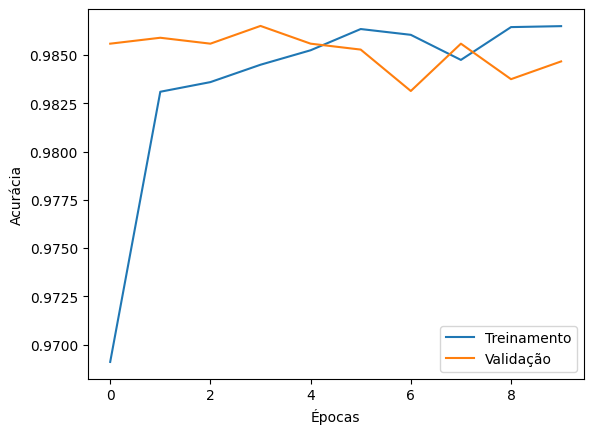

In [ ]:
# Avaliar o modelo
val_loss, val_acc = model.evaluate(val_data)
print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

# Visualizar curvas de aprendizado
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


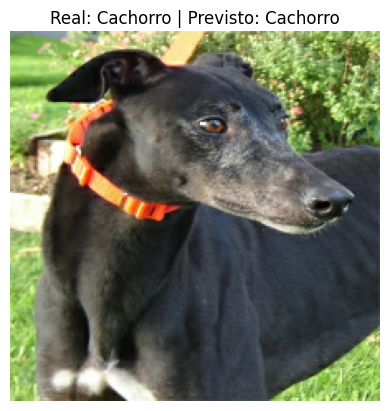

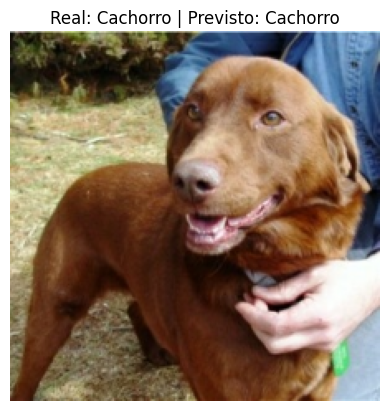

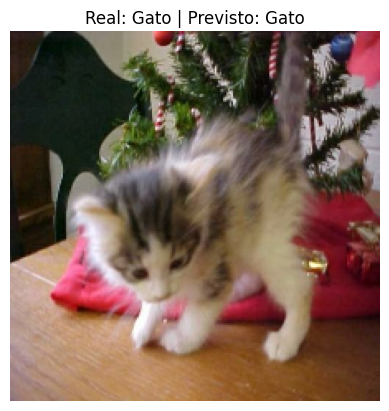

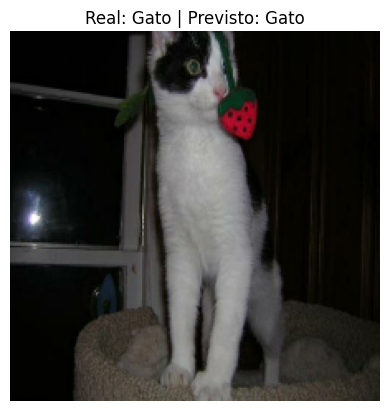

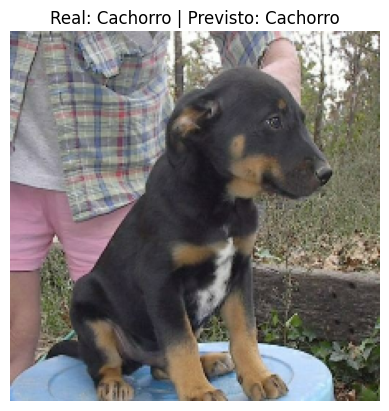

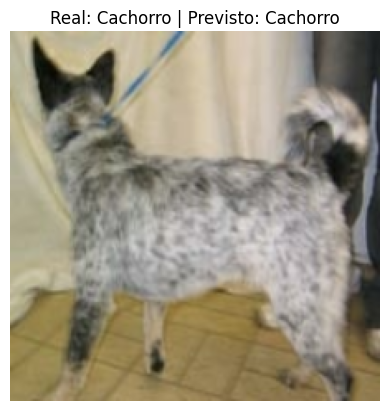

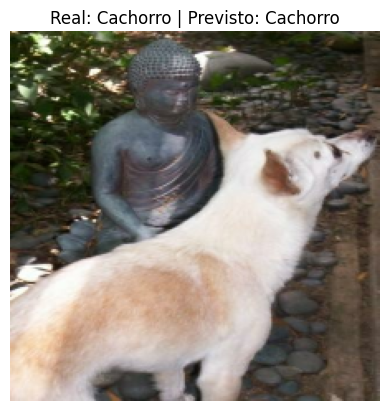

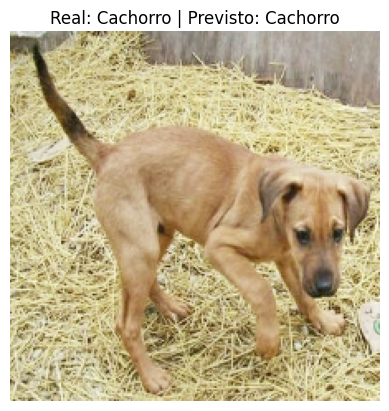

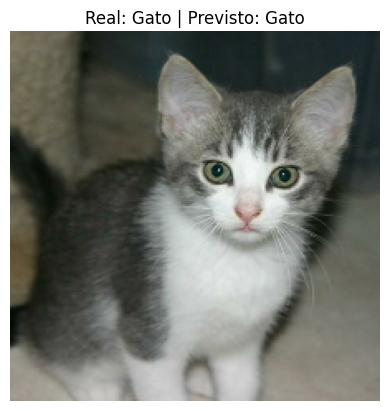

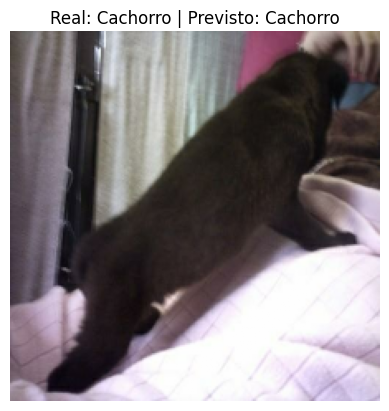

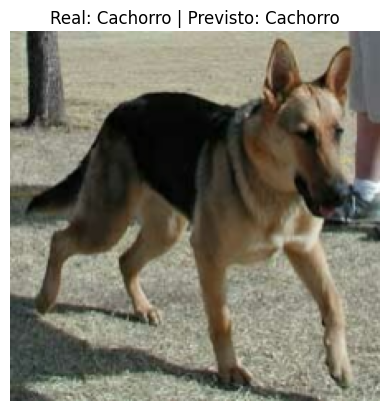

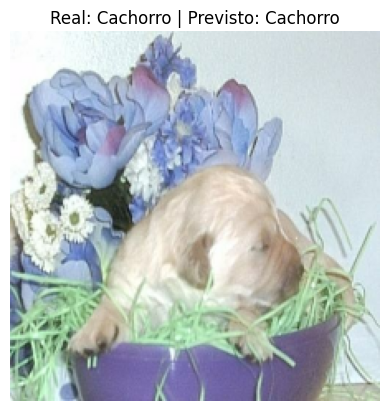

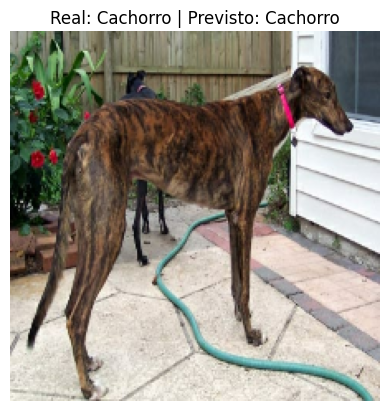

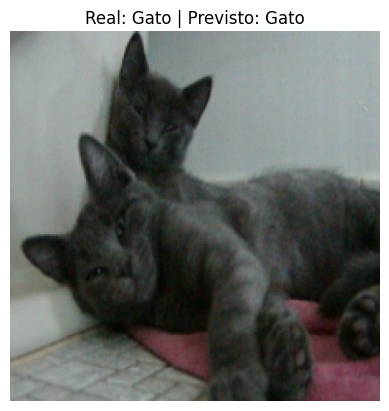

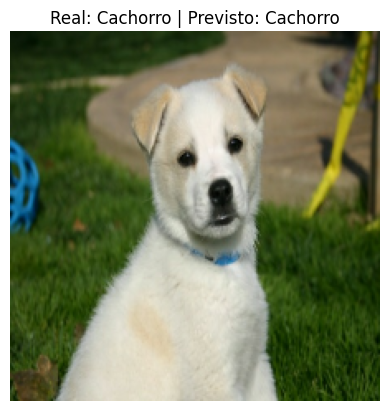

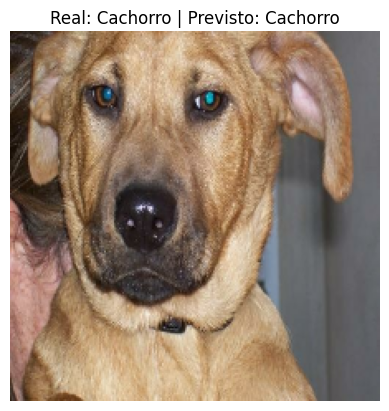

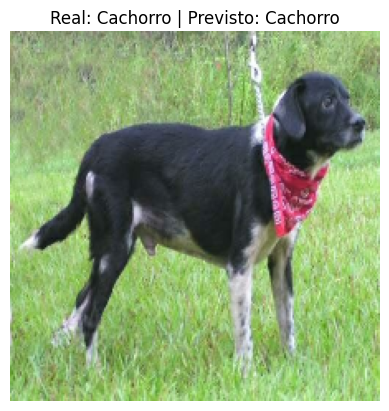

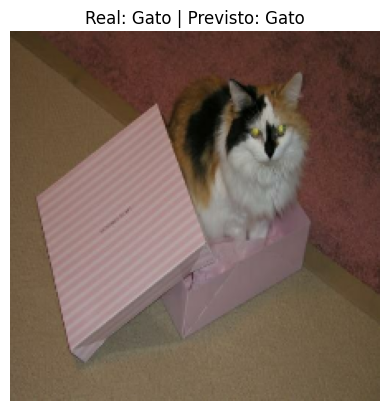

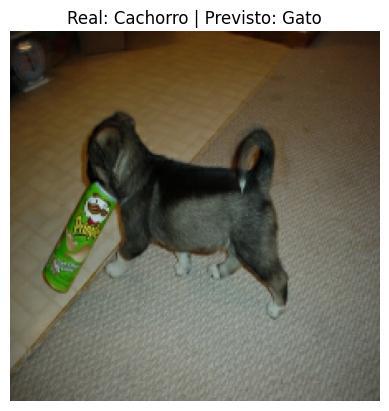

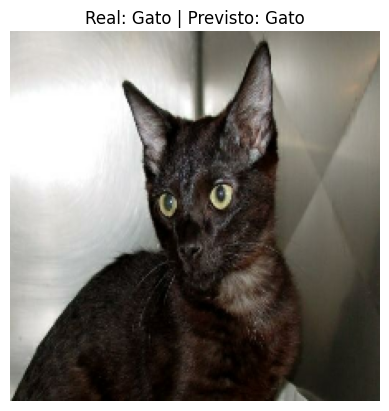

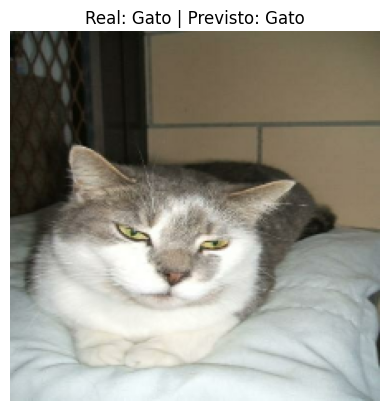

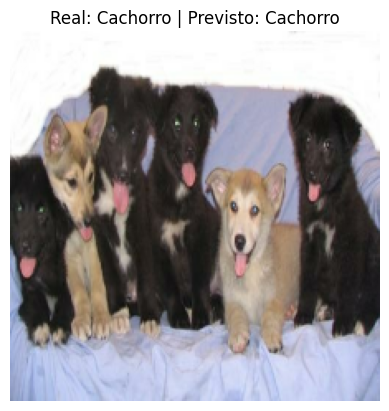

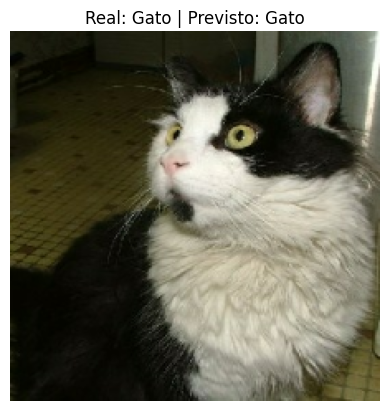

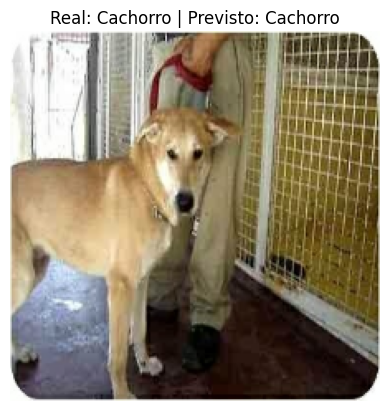

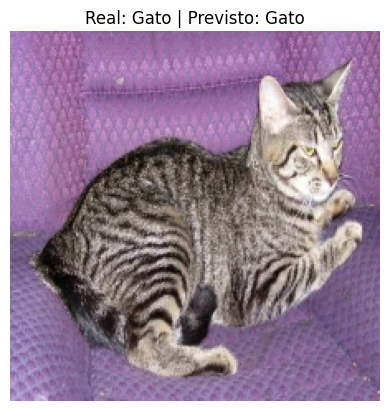

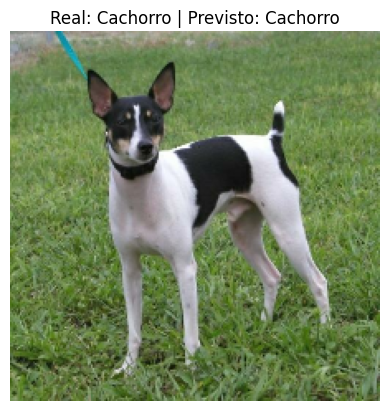

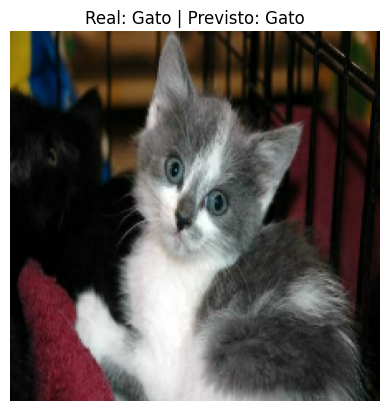

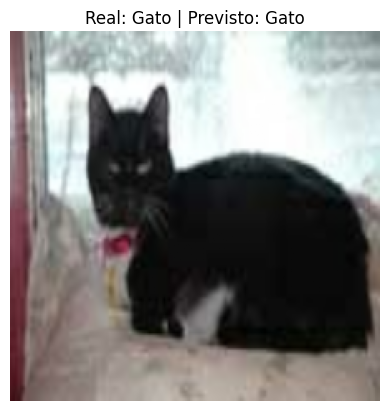

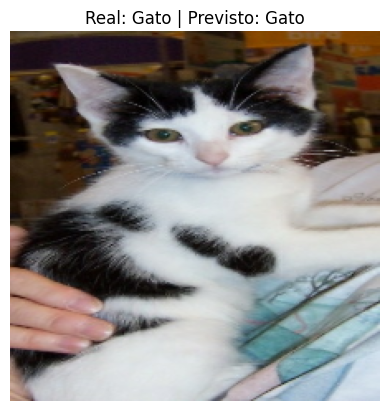

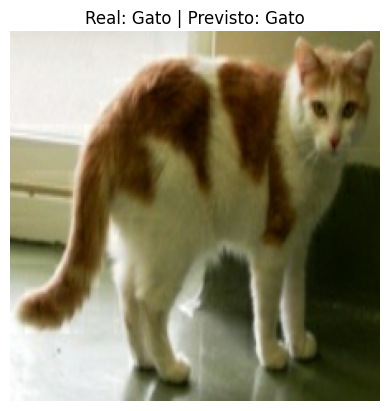

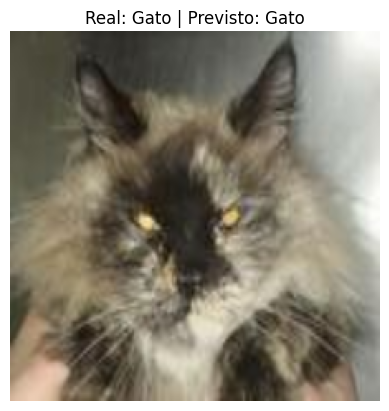

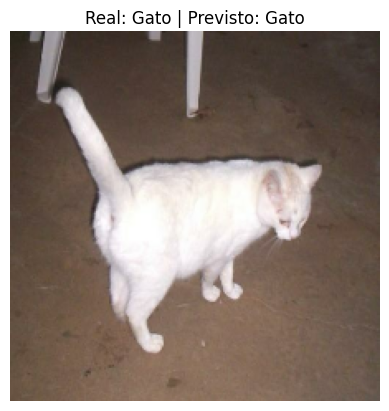

In [ ]:
# Obter um lote do conjunto de validação
for images, labels in val_data.take(1):  # Pega o primeiro lote
    predictions = model.predict(images)  # Fazer previsões
    break

# Mostrar as imagens e previsões
for i in range(len(images)):
    plt.imshow(images[i].numpy())
    plt.axis('off')
    plt.title(f"Real: {'Cachorro' if labels[i].numpy() == 1 else 'Gato'} | Previsto: {'Cachorro' if predictions[i] > 0.5 else 'Gato'}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Previsto: Cachorro


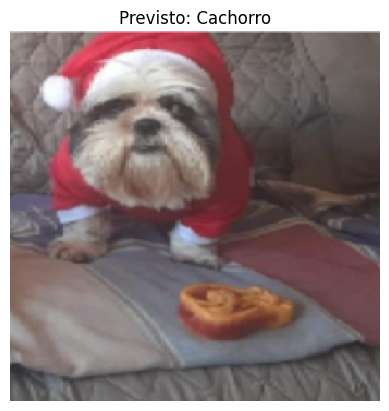

In [28]:
from tensorflow.keras.preprocessing import image

# Caminho para a nova imagem
image_path = '/content/teste2.png'

# Carregar a imagem
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0  # Normalizar
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do lote

# Fazer previsão
prediction = model.predict(img_array)

# Exibir resultado
print(f"Previsto: {'Cachorro' if prediction[0] > 0.5 else 'Gato'}")
plt.imshow(img)
plt.axis('off')
plt.title(f"Previsto: {'Cachorro' if prediction[0] > 0.5 else 'Gato'}")
plt.show()
